In [16]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
import pandas as pd
from binance.client import Client

client = Client()

klines = client.get_historical_klines(
    symbol = "BTCUSDT",
    interval = Client.KLINE_INTERVAL_1DAY,
    start_str = "1 Aug 2025",
    end_str = "1 Jan 2026"
)

df = pd.DataFrame(klines, columns=[
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_volume", "trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
])

df["open_time"] = pd.to_datetime(df["open_time"], unit = "ms")
df = df[["open_time", "open", "high", "low", "close", "volume"]]


df.to_csv("BTCUSDT_1d.csv", index = False)

In [3]:
df["open_time"] = pd.to_datetime(df["open_time"])
cols = ["open", "high", "low", "close", "volume"]
df[cols] = df[cols].astype(float)

df = df.sort_values("open_time")
df = df.set_index("open_time")

In [4]:
df = df.asfreq("1D")



Базовые производные признаки 

In [ ]:

# доходность
df["return"] = df["close"].pct_change()
df["log_return"] = np.log(df["close"] / df["close"].shift(1))

In [7]:
# волатильность

df["hl_range"] = (df["high"] - df["low"]) / df["close"]
df["oc_range"] = (df["close"] - df["open"]) / df["open"]


In [8]:
# тело и тени свечи

df["body"] = (df["close"] - df["open"]).abs()
df["upper_wick"] = df["high"] - df[["open", "close"]].max(axis=1)
df["lower_wick"] = df[["open", "close"]].min(axis=1) - df["low"]

In [9]:
# скользящие средние

df["sma_20"] = df["close"].rolling(20).mean()
df["sma_50"] = df["close"].rolling(50).mean()
df["ema_20"] = df["close"].ewm(span=20).mean()

In [10]:
# RSI 

delta = df["close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1+rs))

In [11]:
# ATR (волатильность)

tr = pd.concat([
    df["high"] - df["low"],
    (df["high"] - df["close"].shift()).abs(),
    (df["low"] - df["close"].shift()).abs()
], axis=1).max(axis=1)

df["atr"] = tr.rolling(14).mean()


In [ ]:
for lag in [1, 2, 3, 5, 10]:
    df[f"return_lag_{lag}"] = df["return"].shift(lag)


In [12]:
df["vol_7"] = df["return"].rolling(7).std()
df["vol_30"] = df["return"].rolling(30).std()


In [13]:
df["dist_sma20"] = (df["close"] - df["sma_20"]) / df["close"]


In [14]:
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)


In [15]:
df = df.dropna()

Аналитика 

In [17]:
print(df.index.min(), df.index.max())
print(len(df))

2025-09-19 00:00:00 2026-01-01 00:00:00
105


<Axes: title={'center': 'Цена и SMA'}, xlabel='open_time'>

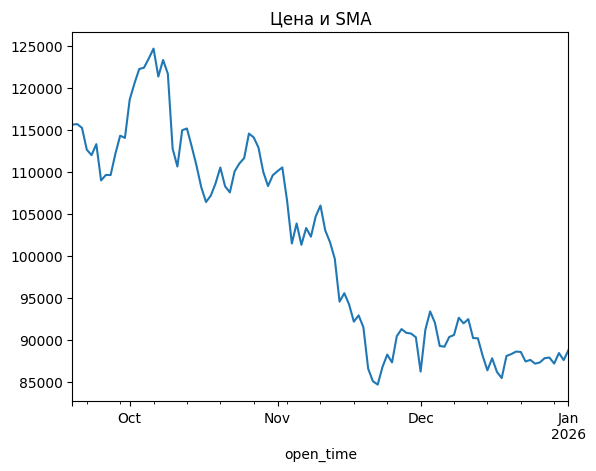

In [ ]:
df["close"].plot(title="Цена и SMA") # цена закрытия

<Axes: title={'center': 'Цена и SMA'}, xlabel='open_time'>

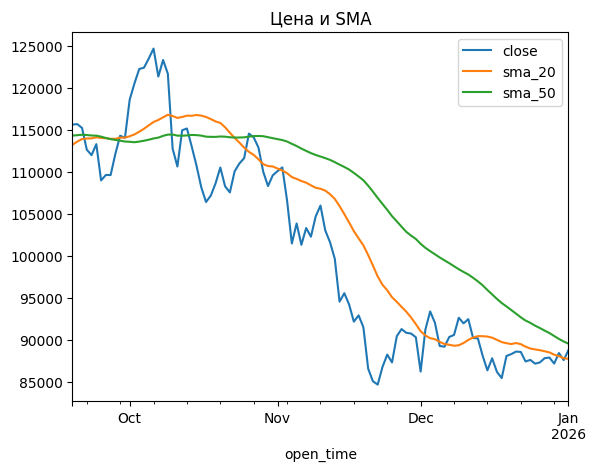

In [19]:
# скользящие средние

df[["close", "sma_20", "sma_50"]].plot(title="Цена и SMA")

<Axes: >

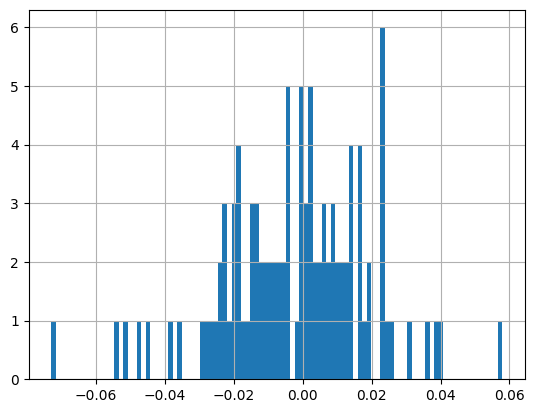

In [20]:
# распределение доходностей

df["return"].hist(bins=100)

<Axes: title={'center': '30-дневная волатильность'}, xlabel='open_time'>

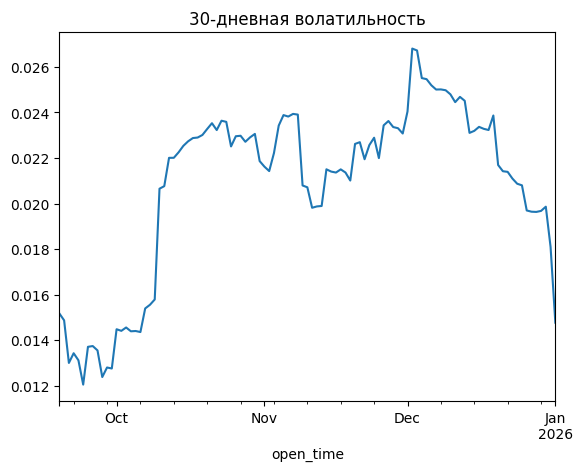

In [21]:
# волатильность 

df["vol_30"].plot(title="30-дневная волатильность")

<Axes: title={'center': 'Объем торгов'}, xlabel='open_time'>

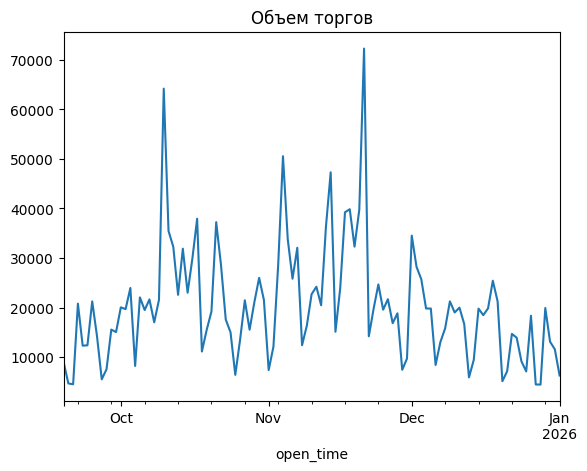

In [22]:
# Объем торговли

df["volume"].plot(title="Объем торгов")

<Axes: >

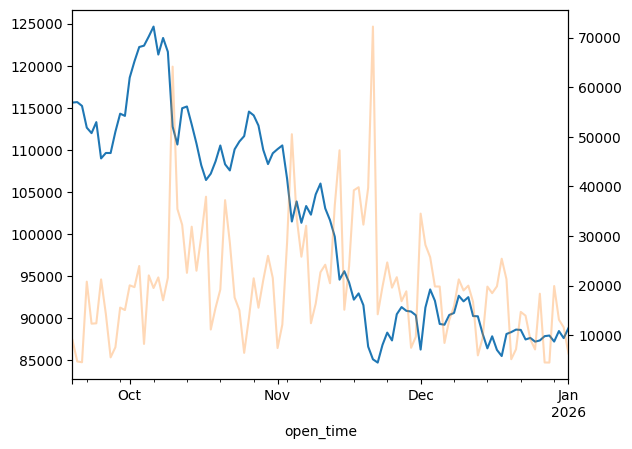

In [ ]:
df["close"].plot()
df["volume"].plot(secondary_y=True, alpha=0.3)



<Axes: >

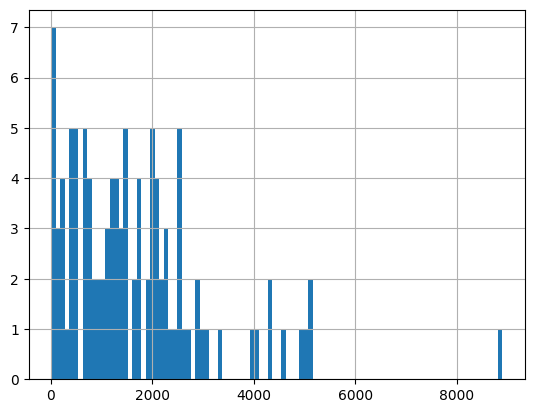

In [24]:
df["body"].hist(bins=100)

<Axes: xlabel='open_time'>

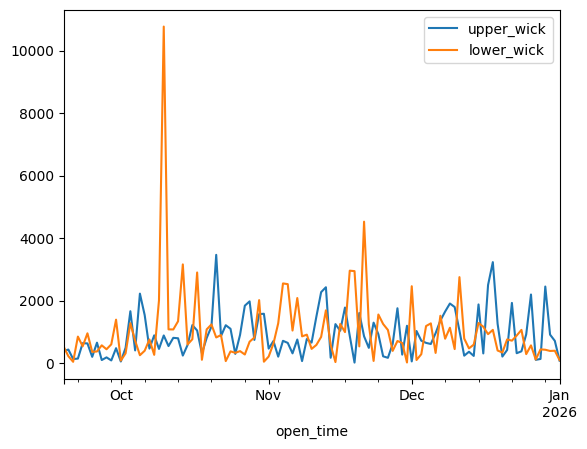

In [25]:
df[["upper_wick", "lower_wick"]].plot()



<Axes: title={'center': 'RSI'}, xlabel='open_time'>

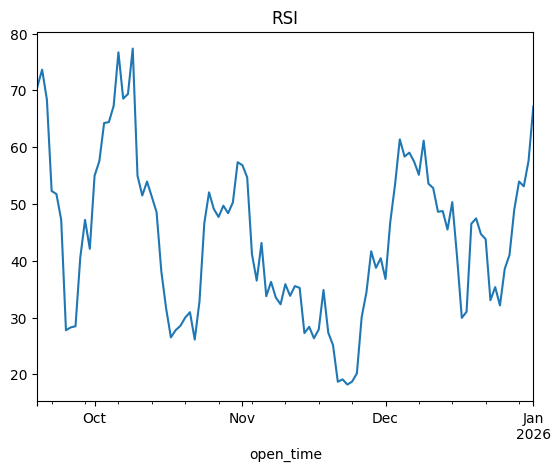

In [26]:
df["rsi"].plot(title="RSI")

In [28]:
df["vol_regime"] = pd.qcut(df["vol_30"], q=3, labels=["low", "mid", "high"])
df.groupby("vol_regime")["return"].mean()


C:\Users\User\AppData\Local\Temp\ipykernel_21124\299591696.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("vol_regime")["return"].mean()


vol_regime
low    -0.001614
mid    -0.005097
high   -0.000494
Name: return, dtype: float64